My first run through this experimentation will be following the model from the paper [Artist Identification with Convulutional Neural Networks](http://cs231n.stanford.edu/reports/2017/pdfs/406.pdf), and working with the [same dataset from Kaggle](https://www.kaggle.com/c/painter-by-numbers). I will initially only be working with a subset of the dataset, train_1.zip, partly due to my ISP's data caps and my current computer setup. In the following month I hope to be able to download more of the data set. I will be using PyTorch for my neural network(s).

In [2]:
%matplotlib inline

In [3]:
import csv
import os
from os.path import expanduser

#trim the irrelevant files; make a csv of our subset of the data
data_dir = expanduser("~") +"/Data/"
all_artist_data = data_dir + "all_artist_data.csv"
train1_csv = data_dir + "artist_train1.csv"
artist_train = data_dir + "artist_train1"

with open(train1_csv, "w") as to_write, open(all_artist_data) as to_read:
    files = set(os.listdir(artist_train))
    writer = csv.writer(to_write, delimiter=",",quotechar='\"')

    reader = csv.reader(to_read, quotechar='\"')
    header = next(reader)
    writer.writerow(header)
    for row in reader:
        if row[-1] in files:
            writer.writerow(row)

In [4]:
art_map = {}

with open(train1_csv, "r", encoding="utf8") as csvfile:
    reader = csv.reader(csvfile, quotechar='\"')
    header = next(reader)
    for row in reader:
        art_map[row[-1]] = row[0]
        


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaslineCNN(nn.Module):
    
    def __init__(self):
        super(BaslineCNN, self).__init__()
        # 3 input image channels, 224 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3,32,3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32,56,3, stride=2, padding=1)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(1, 6272)
        self.fc2 = nn.Linear(2, 228)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
        
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = BaslineCNN()
print(net)
    
    

BaslineCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=1, out_features=6272, bias=True)
  (fc2): Linear(in_features=2, out_features=228, bias=True)
)


In [16]:
import pandas as pd
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
from PIL import Image

train_loader_transform = transforms.Compose([transforms.RandomCrop(224),
                                             transforms.ToTensor()])

# custom loading solution found on StackOverflow:
# https://stackoverflow.com/questions/50052295/how-do-you-load-images-into-pytorch-dataloader

class ArtistImageDataset(torch.utils.data.Dataset):
    def __init__(self,text_file,img_dir,transform=train_loader_transform):
        self.name_frame = pd.read_csv(text_file,sep=",",usecols=range(11,12))
        self.label_frame = pd.read_csv(text_file,sep=",",usecols=range(1))
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.name_frame)

    def __getitem__(self, index):
        img_name = os.path.join(self.img_dir, self.name_frame.iloc[index, 0])
        image = Image.open(img_name)
        image = self.transform(image)
        labels = self.label_frame.iloc[index, 0]
        sample = {'image': image, 'labels': labels}

        return sample
    
artistImageTrainSet = ArtistImageDataset(text_file=train1_csv, img_dir = artist_train)

artistTrainLoader = torch.utils.data.DataLoader(
    artistImageTrainSet,
    batch_size=16,
    shuffle=True,
    num_workers=2)

Eugene Boudin,Pablo Picasso,Remedios Varo,Leonardo da Vinci,Mstislav Dobuzhinsky,Henry William Banks Davis,Piero della Francesca,Boris Kustodiev,Georges Braque,Georges Seurat,Jean Auguste Dominique Ingres,Rembrandt,Ken Danby,Toyota Hokkei,Alfred Sisley,Tano Festa


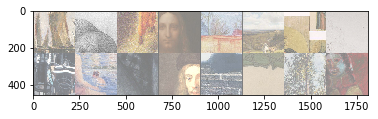

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(artistTrainLoader)
sample = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(sample['image']))
# print labels
print(','.join(sample['labels']))